In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy.special import gamma
from jax.scipy.special import gammaincc

from scipy.stats import gamma as gamma_pdf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The following piece-wise function is the convolution of a gamma pdf (support x>=0) with 
# a biweight kernel (support: -s < x < s and continuous derivative).

# Per Mathematica it is the solution to the following integral
# \int_{-s}^{\infty}du {15./(16.*s) * (1.0-((x-u)/s)**2)**2} * {b^a/Gamma[a]*u^(a-1)*Exp[-bu]}.

# We can assume that a > 1 (no singularity for gamma pdf at x = 0) and s > 1 (width of biweight kernel).

In [12]:
def branch0(x, a, b, sigma):
    # branch 0 (-s < x < +s)
    s = 3.0 * sigma
    
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_3pa = gamma(3+a)
    g_4pa = gamma(4+a)

    bspx = b*(s+x)

    gincc_a = gammaincc(a, bspx) * g_a
    gincc_1pa = gammaincc(1+a, bspx)*g_1pa
    gincc_2pa = gammaincc(2+a, bspx)*g_2pa
    gincc_3pa = gammaincc(3+a, bspx)*g_3pa
    gincc_4pa = gammaincc(4+a, bspx)*g_4pa

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)

    tsum0 = (
                (g_a - gincc_a) * t0
                + (g_1pa - gincc_1pa) * t1
                + (g_2pa - gincc_2pa) * t2
                + g_4pa - gincc_4pa
                + gincc_3pa * fbx
                - g_2pa * (2*fbx + a*fbx)
    )

    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum0

In [13]:
def branch1(x, a, b, sigma):
    s = 3.0 * sigma
    # branch 1 (s > x)

    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_3pa = gamma(3+a)
    g_4pa = gamma(4+a)

    bspx = b*(s+x)
    bxms = b*(x-s)
    
    gincc_a = gammaincc(a, bspx) * g_a
    gincc_1pa = gammaincc(1+a, bspx)*g_1pa
    gincc_2pa = gammaincc(2+a, bspx)*g_2pa
    gincc_3pa = gammaincc(3+a, bspx)*g_3pa
    gincc_4pa = gammaincc(4+a, bspx)*g_4pa

    gincc_a_m = gammaincc(a, bxms) * g_a
    gincc_1pa_m = gammaincc(1+a, bxms)*g_1pa
    gincc_2pa_m = gammaincc(2+a, bxms)*g_2pa
    gincc_3pa_m = gammaincc(3+a, bxms)*g_3pa
    gincc_4pa_m = gammaincc(4+a, bxms)*g_4pa

    fbx = 4*b*x
    t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
    t1 = 4*b**3 * (s**2*x - x**3)
    t2 = b**2 * (6*x**2 - 2*s**2)

    tsum1 = (
                (gincc_a_m - gincc_a) * t0
                + (gincc_1pa_m - gincc_1pa) * t1
                + (gincc_2pa_m - gincc_2pa) * t2
                + (gincc_3pa - gincc_3pa_m) * fbx
                + gincc_4pa_m - gincc_4pa
    )

    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum1

In [22]:
def combined_less_or_equal(x, a, b, sigma):
    s = 3.0 * sigma
    
    x0 = jnp.where(x <= s, x, s)
    b0 = branch0(x0, a, b, sigma)
    
    x1 = jnp.where(x <= s, s, x)
    b1 = branch1(x1, a, b, sigma)
    
    return jnp.where(x <= s, b0, b1)

def combined_less(x, a, b, sigma):
    s = 3.0 * sigma
    x0 = jnp.where(x < s, x, s)
    b0 = branch0(x0, a, b, sigma)
    
    x1 = jnp.where(x < s, s, x)
    b1 = branch1(x1, a, b, sigma)
    return jnp.where(x < s, b0, b1)

def gamma_pdf_eval(x, a, b):
    y = gamma_pdf.pdf(x, a, scale=1/b)
    y = np.where(x <= 0, 0.0, y)
    return y

In [23]:
a = 3.75
b = 0.5
sigma = 3.0

xvals = np.linspace(-3*sigma, 50, 10000)

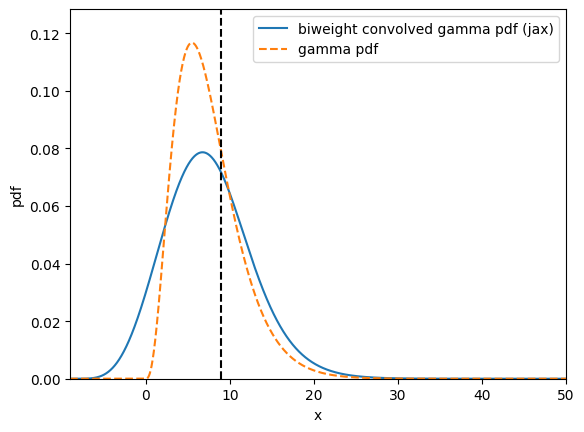

In [24]:
plt.figure()

yg = gamma_pdf_eval(xvals, a, b)
yg_jax = combined_less_or_equal(xvals, a, b, sigma)

plt.plot(xvals, yg_jax, label='biweight convolved gamma pdf (jax)')
plt.plot(xvals, yg, label='gamma pdf', linestyle='dashed')
plt.axvline(3.0*sigma, color='black', linestyle='dashed')
plt.xlabel('x')
plt.ylabel('pdf')
plt.xlim([-9.0, 50.0])
plt.ylim([0.0, 1.1 * np.max(yg)])
plt.legend()
plt.show()

In [25]:
# Define gradients w.r.t a and b parameters.
branch0_grad = jax.grad(branch0, argnums=(1, 2))
branch1_grad = jax.grad(branch1, argnums=(1, 2))
combined_leq_grad = jax.grad(combined_less_or_equal, argnums=(1, 2))
combined_less_grad = jax.grad(combined_less, argnums=(1, 2))

In [26]:
# Let's also define some finite differences near the boundary
def finite_difference_grad_left(x, a, b, sigma, eps = 1.e-5):
    eps = 1.e-5

    # grad in a
    a0 = a + eps
    a1 = a - eps
    grad_a = 0.5/eps * (branch0(x, a0, b, sigma) - branch0(x, a1, b, sigma))

    # grad in b 
    b0 = b + eps
    b1 = b - eps
    grad_b = 0.5/eps * (branch0(x, a, b0, sigma) - branch0(x, a, b1, sigma))
    
    return jnp.array([grad_a, grad_b])


def finite_difference_grad_right(x, a, b, sigma, eps = 1.e-5):
    eps = 1.e-5

    # grad in a
    a0 = a + eps
    a1 = a - eps
    grad_a = 0.5/eps * (branch1(x, a0, b, sigma) - branch1(x, a1, b, sigma))

    # grad in b 
    b0 = b + eps
    b1 = b - eps
    grad_b = 0.5/eps * (branch1(x, a, b0, sigma) - branch1(x, a, b1, sigma))
    
    return jnp.array([grad_a, grad_b])

In [27]:
# x == s (s=9.0)
x = 9.0
print("gradient left: ", branch0_grad(x, a, b, sigma))
print("gradient right:", branch1_grad(x, a, b, sigma))
print("gradient left(finite-diff): ", finite_difference_grad_left(x, a, b, sigma))
print("gradient right(finite-diff): ", finite_difference_grad_right(x, a, b, sigma))
print("combined gradient (using <=):", combined_leq_grad(x, a, b, sigma))
print("combined gradient (using <): ", combined_less_grad(x, a, b, sigma))

gradient left:  (Array(0.0070825, dtype=float64, weak_type=True), Array(-0.01597369, dtype=float64, weak_type=True))
gradient right: (Array(0.0070825, dtype=float64, weak_type=True), Array(-0.01597369, dtype=float64, weak_type=True))
gradient left(finite-diff):  [ 0.0070825  -0.01597369]
gradient right(finite-diff):  [ 0.0070825  -0.01597369]
combined gradient (using <=): (Array(0.0070825, dtype=float64, weak_type=True), Array(-0.01597369, dtype=float64, weak_type=True))
combined gradient (using <):  (Array(0.0070825, dtype=float64, weak_type=True), Array(-0.01597369, dtype=float64, weak_type=True))


In [28]:
# x > s (s=9.0)
x = 20.0
print("gradient right:", branch1_grad(x, a, b, sigma))
print("gradient right(finite-diff): ", finite_difference_grad_right(x, a, b, sigma))
print("combined gradient (using <=):", combined_leq_grad(x, a, b, sigma))
print("combined gradient (using <): ", combined_less_grad(x, a, b, sigma))

gradient right: (Array(0.00492074, dtype=float64, weak_type=True), Array(-0.04853138, dtype=float64, weak_type=True))
gradient right(finite-diff):  [ 0.00492074 -0.04853138]
combined gradient (using <=): (Array(0.00492074, dtype=float64, weak_type=True), Array(-0.04853138, dtype=float64, weak_type=True))
combined gradient (using <):  (Array(0.00492074, dtype=float64, weak_type=True), Array(-0.04853138, dtype=float64, weak_type=True))


In [29]:
# x < s (s=9.0)
x = 0.0
print("gradient left: ", branch0_grad(x, a, b, sigma))
print("gradient left (finite-diff): ", finite_difference_grad_left(x, a, b, sigma))
print("combined gradient (using <=):", combined_leq_grad(x, a, b, sigma)) # notice the nan when combining via jnp.where.
print("combined gradient (using <): ", combined_less_grad(x, a, b, sigma)) # notice the nan when combining via jnp.where.

gradient left:  (Array(-0.01648117, dtype=float64, weak_type=True), Array(0.10139461, dtype=float64, weak_type=True))
gradient left (finite-diff):  [-0.01648117  0.10139461]
combined gradient (using <=): (Array(-0.01648117, dtype=float64, weak_type=True), Array(0.10139461, dtype=float64, weak_type=True))
combined gradient (using <):  (Array(-0.01648117, dtype=float64, weak_type=True), Array(0.10139461, dtype=float64, weak_type=True))


In [30]:
# just FYI

def biweight(x, u, s):
    y =  15./(16.*s) * (1.0-((x-u)/s)**2)**2
    y = np.where(np.abs(x-u) <= s, y, 0.0)
    return y

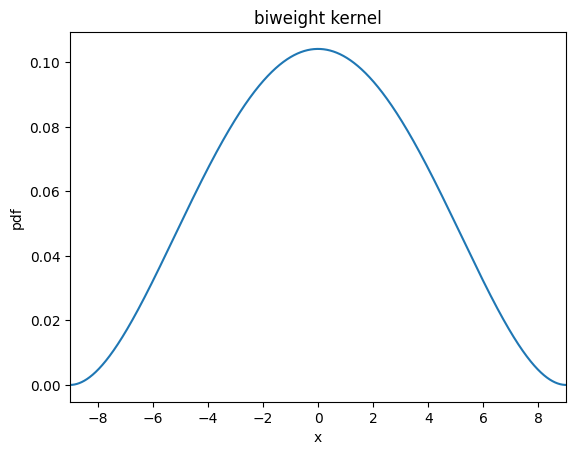

In [31]:
plt.title('biweight kernel')
plt.plot(xvals, biweight(xvals, 0.0, 3.0*sigma))
plt.xlim([-3*sigma, 3*sigma])
plt.xlabel('x')
plt.ylabel('pdf')
plt.show()